<a href="https://colab.research.google.com/github/ParthikB/GANs/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# Upload the 'utils.py' file onto Colab (if you're using Colab) using the upload button on the left side of the screen under the Files panel.

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

from utils import Logger
from tqdm import tqdm
from IPython import display

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    running_on = 'GPU'
else:
    device = torch.device('cpu')
    running_on = 'CPU'
print(f'Torch running on : {running_on}')

Torch running on : GPU


## Helper Functions

In [0]:
def images_to_vector(image):
    return image.view(image.size(0), 784)

def vector_to_images(vector):
    return vector.view(vector.size(0), 1, 28, 28)

# Creating random noise to feed into the Generator
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    return n.to(device)

def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data.to(device)

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data.to(device)

## Importing and Transforming the Data

In [0]:
''' 
Downloading the inbuild FashionMNIST Dataset. 
You can use your own dataset, don't forget to customize the Dimensions in the Network Class below according the the data being used.
'''
data = datasets.FashionMNIST('', train=True, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))

data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)

num_batches = len(data_loader)

## Defining the Discriminator Network

In [0]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        INPUT_FEATURES = 784
        OUTPUT_NODES   = 1
        
        self.layer1 = nn.Sequential(
                        nn.Linear(INPUT_FEATURES, 1024),
                        nn.LeakyReLU(0.2),
                        nn.Dropout(0.3)
                        )
        
        self.layer2 = nn.Sequential(
                        nn.Linear(1024, 512),
                        nn.LeakyReLU(0.2),
                        nn.Dropout(0.3)
                        )
        
        self.layer3 = nn.Sequential(
                        nn.Linear(512, 256),
                        nn.LeakyReLU(0.2),
                        nn.Dropout(0.3)
                        )
        
        self.output = nn.Sequential(
                        nn.Linear(256, OUTPUT_NODES),
                        nn.Sigmoid()
                        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)            
        x = self.layer3(x)            
        x = self.output(x)
        return x

## Defining the Generative Network

In [0]:
class Generative(torch.nn.Module):
    def __init__(self):
        super(Generative, self).__init__()
        INPUT_FEATURES = 100
        OUTPUT_NODES   = 784
        
        self.layer1 = nn.Sequential(
                        nn.Linear(INPUT_FEATURES, 256),
                        nn.LeakyReLU(0.2)
                        )
        
        self.layer2 = nn.Sequential(
                        nn.Linear(256, 512),
                        nn.LeakyReLU(0.2)
                        )
        
        self.layer3 = nn.Sequential(
                        nn.Linear(512, 1024),
                        nn.LeakyReLU(0.2)
                        )
        
        self.output = nn.Sequential(
                        nn.Linear(1024, OUTPUT_NODES),
                        nn.Tanh()
                        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)            
        x = self.layer3(x)            
        x = self.output(x)
        return x

In [0]:
# Function used to train the discriminator and minimize the d_loss
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake


# Function used to train the generator and minimize the g_loss
def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

# Putting all together

In [0]:
# Creating the respective networks
discriminator = Discriminator().to(device)
generator     = Generative().to(device)

# Defining the respective optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4)
g_optimizer = optim.Adam(generator.parameters(), lr=2e-4)

# Loss --> Binary Cross Entropy
loss = nn.BCELoss()

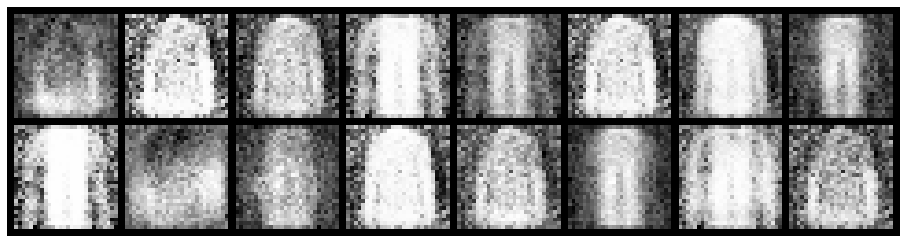

Epoch: [9/10], Batch Num: [500/600]
Discriminator Loss: 1.1101, Generator Loss: 1.5253
D(x): 0.6028, D(G(z)): 0.2761




100%|██████████| 10/10 [29:02<00:00, 175.49s/it]



In [26]:
EPOCHS           = 10  # Total number of epochs to train
NUM_TEST_SAMPLES = 16  # Number of Test Samples to Display

# Create logger instance
logger = Logger(model_name='VGAN', data_name='MNIST')

test_noise = noise(NUM_TEST_SAMPLES)

for epoch in tqdm(range(EPOCHS)):
    for n_batch, (real_batch,_) in enumerate(data_loader):

        # 1. Train Discriminator
        real_data = Variable(images_to_vector(real_batch)).to(device)
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)

        # Display Progress
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = vector_to_images(generator(test_noise)).data.cpu()
            logger.log_images(test_images, NUM_TEST_SAMPLES, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, EPOCHS, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        # Model Checkpoints
        logger.save_models(generator, discriminator, epoch)